# Apple Mobility Data Analysis

## Packages Data Views

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import kpss
import plotnine
from statsmodels.tsa.seasonal import STL
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.statespace.sarimax import SARIMAX
from plotnine import ggplot, aes, geom_line, labs, theme_minimal
from statsmodels.stats.diagnostic import acorr_ljungbox

In [2]:
df = pd.read_csv("apple-us-mobility-data.csv")

In [3]:
df.head()

,geo_type,region,transportation_type,alternative_name,sub_region,country,date,score
0,sub-region,Alabama,driving,NaN,NaN,United States,2020-01-13,100.00
1,sub-region,Alabama,driving,NaN,NaN,United States,2020-01-14,102.90
2,sub-region,Alabama,driving,NaN,NaN,United States,2020-01-15,103.51
3,sub-region,Alabama,driving,NaN,NaN,United States,2020-01-16,109.71
4,sub-region,Alabama,driving,NaN,NaN,United States,2020-01-17,133.97


In [4]:
df["transportation_type"].unique()

array(['driving', 'walking', 'transit'], dtype=object)

## Extracting Relevant States

In [5]:

states = ["Florida", "California", "Texas", "Pennsylvania", "New York"]

df_states = df[(df['region'].isin(states))]
df_final  = df_states[df_states["transportation_type"] == 'driving']

df_final

,geo_type,region,transportation_type,alternative_name,sub_region,country,date,score
5040,sub-region,California,driving,NaN,NaN,United States,2020-01-13,100.00
5041,sub-region,California,driving,NaN,NaN,United States,2020-01-14,104.39
5042,sub-region,California,driving,NaN,NaN,United States,2020-01-15,109.34
5043,sub-region,California,driving,NaN,NaN,United States,2020-01-16,109.36
5044,sub-region,California,driving,NaN,NaN,United States,2020-01-17,129.78
...,...,...,...,...,...,...,...,...
52915,sub-region,Texas,driving,NaN,NaN,United States,2021-03-03,121.28
52916,sub-region,Texas,driving,NaN,NaN,United States,2021-03-04,127.02
52917,sub-region,Texas,driving,NaN,NaN,United States,2021-03-05,150.83
52918,sub-region,Texas,driving,NaN,NaN,United States,2021-03-06,153.83


In [6]:
df_sorted = df_final.groupby(by=['region', 'date'])['score'].mean().reset_index()

In [7]:
df_sorted

df_sorted['date'] = pd.to_datetime(df_sorted['date'])

In [8]:
plotnine.ggplot(data = df_sorted, mapping=plotnine.aes(x='date', y = 'score', color = "region")) + plotnine.geom_line()

plot = (
    ggplot(df_sorted, aes(x="date", y="score", color="region"))
    + geom_line()
    + labs(
        title="Average Driving Requests Over Time",
        x="Date",
        y="Average Score",
        color="State"
    )
    + theme_minimal()
)


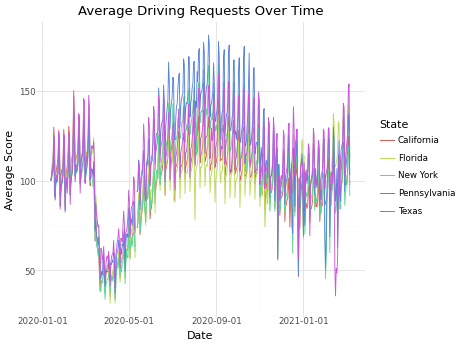

In [9]:
plot.show() 

## Plotting Time Series for a View

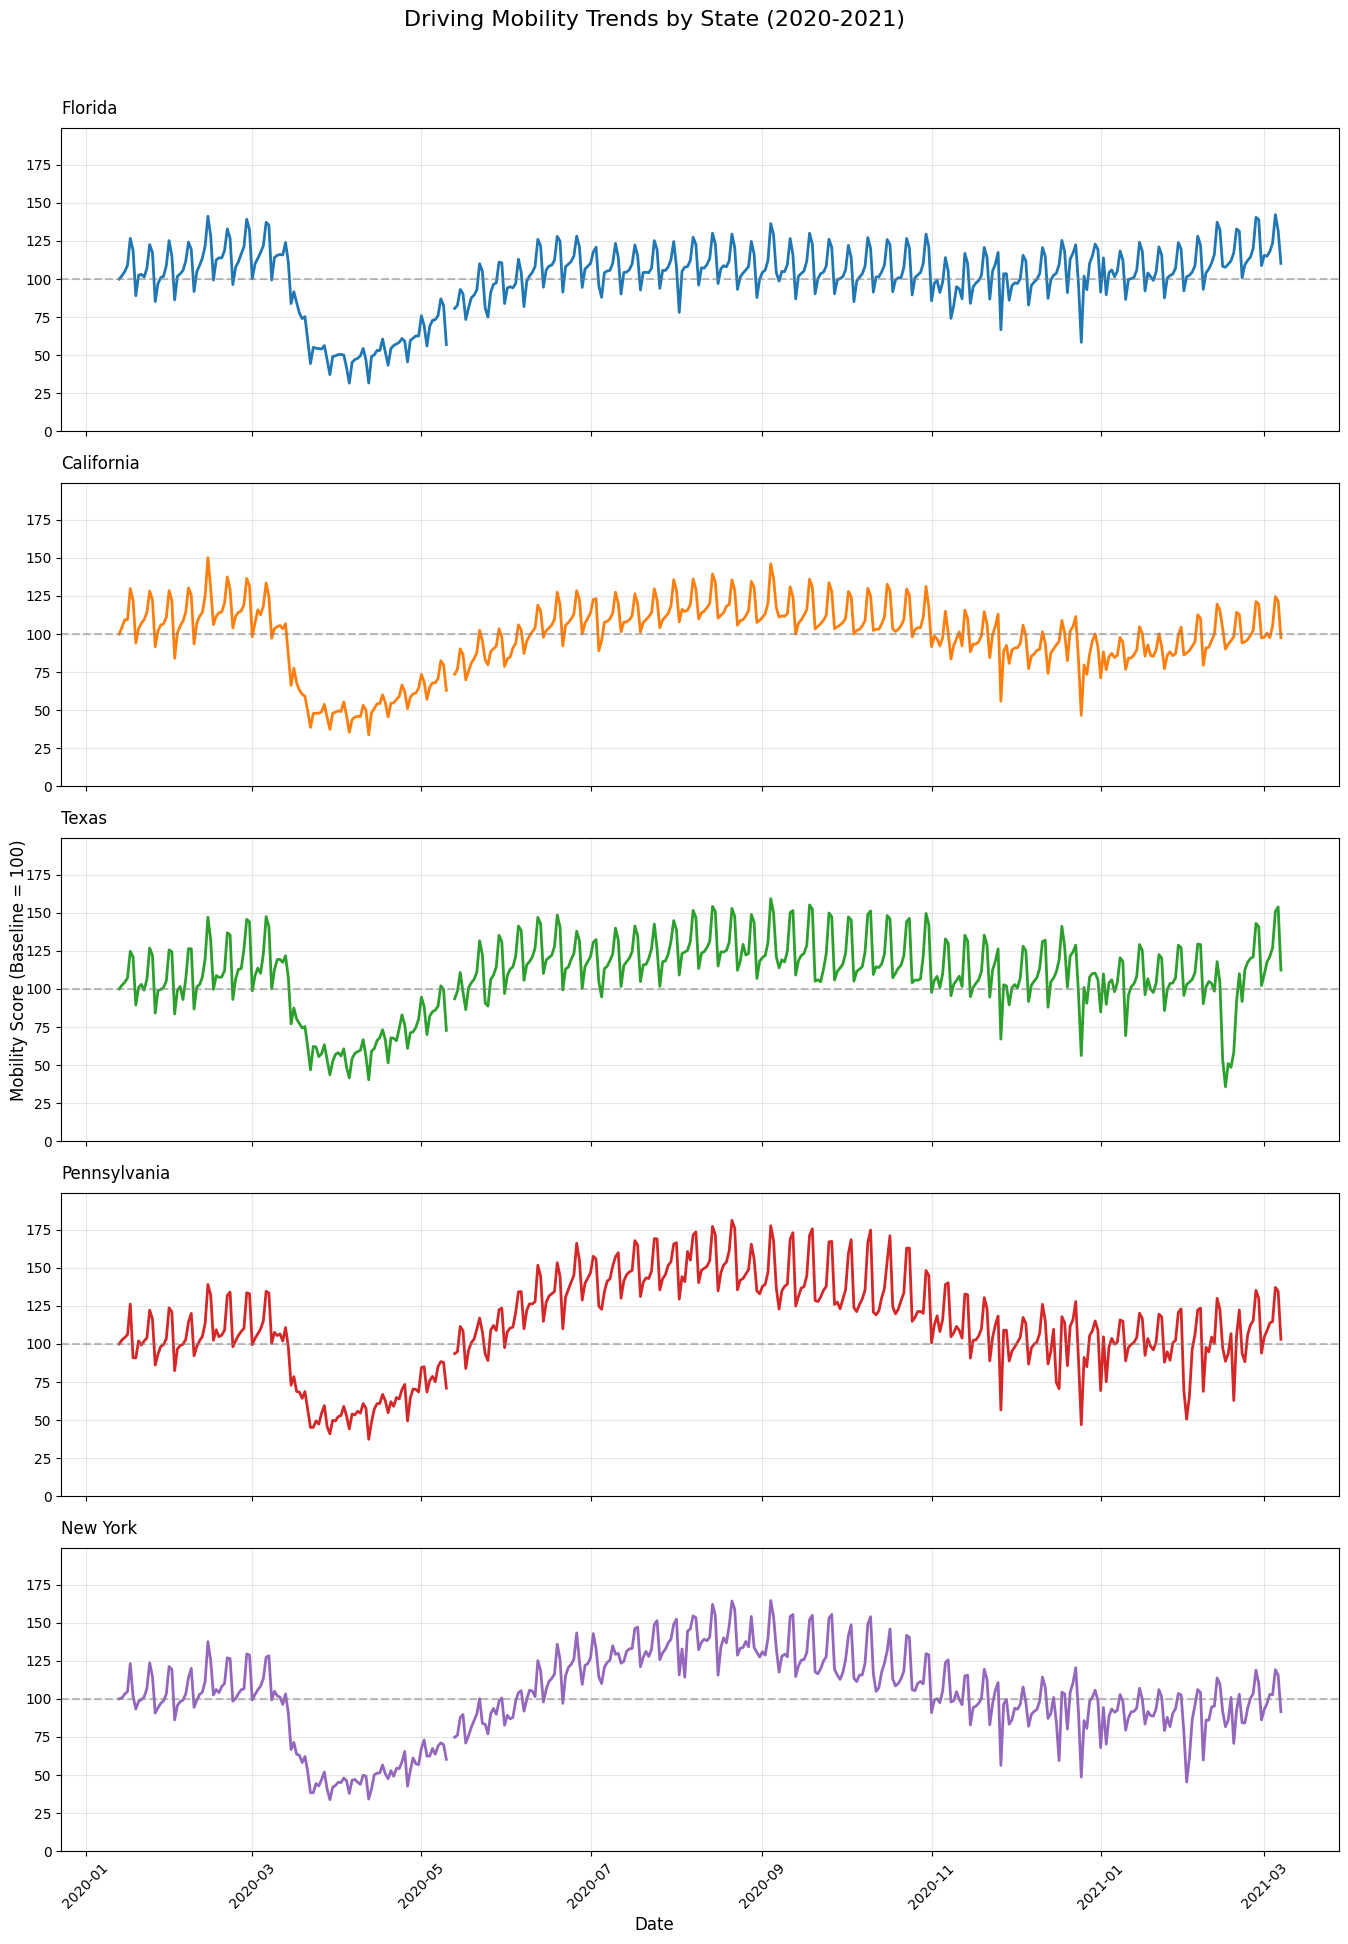

In [10]:
# Create a figure with subplots
fig, axes = plt.subplots(len(states), 1, figsize=(14, 20), sharex=True)

# Plot each state in a separate subplot
for idx, state in enumerate(states):
    state_data = df_sorted[df_sorted['region'] == state]
    ax = axes[idx]
    ax.plot(state_data['date'], state_data['score'], 
           label=state, linewidth=2, color=f'C{idx}')
    
    # Add state name and grid
    ax.set_title(state, fontsize=12, pad=10, loc='left')
    ax.axhline(y=100, color='gray', linestyle='--', alpha=0.5)
    ax.grid(True, alpha=0.3)
    
    # Set y-axis limits
    ax.set_ylim(0, max(df_sorted['score']) * 1.1)

# Add common labels
fig.suptitle('Driving Mobility Trends by State (2020-2021)', fontsize=16, y=0.98)
fig.text(0.5, 0.02, 'Date', ha='center', fontsize=12)
fig.text(0.04, 0.5, 'Mobility Score (Baseline = 100)', 
        va='center', rotation='vertical', fontsize=12)

# Adjust layout
plt.tight_layout(rect=[0.04, 0.04, 1, 0.96])
plt.xticks(rotation=45)
plt.show()

## MACRO LEVEL INSIGHTS BASED ON FIRST IMPRESSIONS:
During the Interview I was a bit confused on the of the meaning of Score I thought of it first as Driving Test scores or something but then came across https://www.apple.com/newsroom/2020/04/apple-makes-mobility-data-available-to-aid-covid-19-efforts/ to understand what this data entails Score is essentially mobility index with amount of driving wrt Jan 13

Insights (besed on my recall of that time): 
Spring 2020 COVID-19 Lockdowns: as I said in the Interview the slump was because of panic among people thats when someone did the World Record on Cannonball (May 2020) interesting story 
 

Gradual Reopening & Summer 2020 Surge
Thats when the incumbent government opened up things that led to catharsis driving among people 

Late 2020 Pandemic Wave:
Driving came down because there was another strain of Covid that spread during that time

Texas February 2021 Freeze:
Texas saw in early 2021 a big freeze so we can see that theres a comparitive lesser rise in mobility index

## Getting the Time Series into a better format for analysis

In [11]:
#df_sorted.columns
ts_df = df_sorted.pivot(index='date', columns='region', values='score')
ts_df = ts_df.asfreq('D').interpolate()
time_series_dict = {region: ts_df[region].dropna() for region in ts_df.columns}

In [12]:
ny_series = time_series_dict['New York']
pa_series = time_series_dict['Pennsylvania']
fl_series = time_series_dict['Florida']
ca_series = time_series_dict['California']
tx_series = time_series_dict['Texas']

In [13]:
ny_series
type(ny_series)

pandas.core.series.Series

# Breaking down STL using STL from Statsmodels

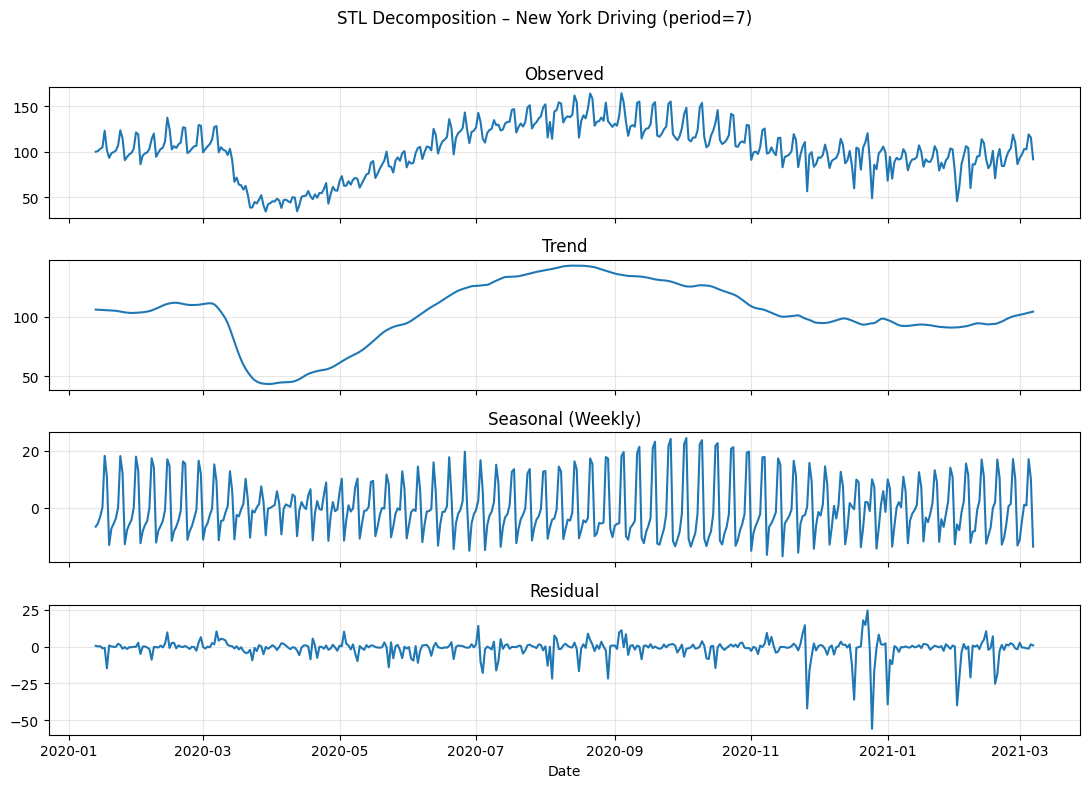

In [14]:
stl = STL(ny_series, period=7, robust=True)
res = stl.fit()

# Plot Observed / Trend / Seasonal / Resid
fig, axes = plt.subplots(4, 1, figsize=(11, 8), sharex=True)
axes[0].plot(ny_series);               axes[0].set_title("Observed")
axes[1].plot(res.trend);       axes[1].set_title("Trend")
axes[2].plot(res.seasonal);    axes[2].set_title("Seasonal (Weekly)")
axes[3].plot(res.resid);       axes[3].set_title("Residual")
for ax in axes: ax.grid(alpha=0.3)
axes[-1].set_xlabel("Date")
fig.suptitle("STL Decomposition – New York Driving (period=7)", y=0.98)
fig.tight_layout(rect=[0,0,1,0.97])
plt.show()

# Access components (if you need them later)
trend = res.trend
seasonal = res.seasonal
residual = res.resid

### INSIGHTS

#### WEEKLY
Clear 7-day cycle: the seasonal component oscillates with a strict weekly period

Day-of-week ranking: Fri ≈ Sat -> Thu/Wed -> Tue -> Mon -> Sun (lowest) approx

#### RESIDUAL

Residual changes around the holiday season with spikes and anamolies around that period

## ACF and PACF of the series

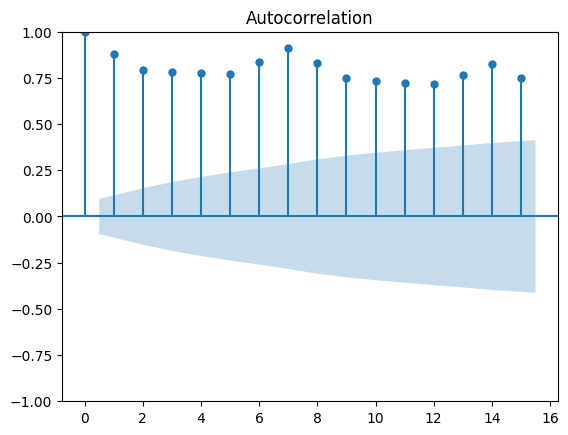

In [15]:
plot_acf(ny_series, lags = 15);

### INSIGHTS
The ACF shows very strong positive autocorrelation that decays slowly.Shows the process is not a MA process it’s likely AR-driven or has seasonality Spike at Lag 7 indicating a weekly seasonal cycle.

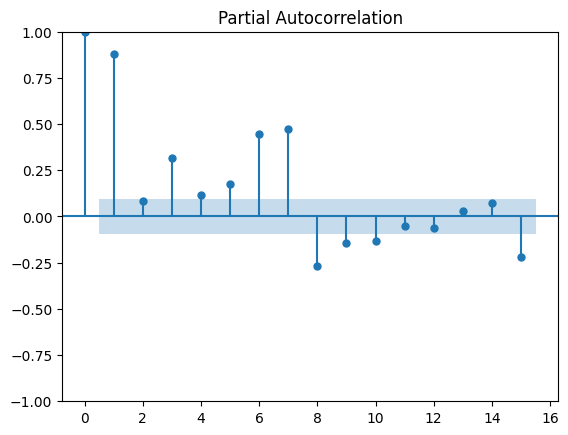

In [16]:
plot_pacf(ny_series, lags = 15);

### INSIGHTS 
The PACF has lag-1 effect. There’s also spike at lag 7, which confirms the weekly seasonality. 
Just based on first looks. I’d start with an AR(1) or AR(2) model with a seasonal AR term at lag 7 a SARIMA with p=1, P=1, and seasonal period=7 (can use AR(4) and AR(6) if needed as they are above significant bands)

## Tests to determine stationarity 
First layer of understanding the time series  


In [17]:
result = adfuller(ny_series)
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ny_diff_result = adfuller(ny_series.diff(1).dropna())
print("ADF Statistic:", ny_diff_result[0])
print("p-value:", ny_diff_result[1])

ny_diff_result_weekly = adfuller(ny_series.diff(7).dropna())
print("ADF Statistic:", ny_diff_result[0])
print("p-value:", ny_diff_result[1])

ADF Statistic: -1.7934850145169254
p-value: 0.38370096667457443
ADF Statistic: -4.524287667722567
p-value: 0.00017769616028035661
ADF Statistic: -4.524287667722567
p-value: 0.00017769616028035661


### INSIGHTS
1. ADF test shows stationarity after diff=1, which means just removing the trend was enough statistically.
2. But theres a 7-day seasonality, I will to apply seasonal differencing (lag 7) to handle seasonality explicitly.

## NY 7 day differenced series PACF

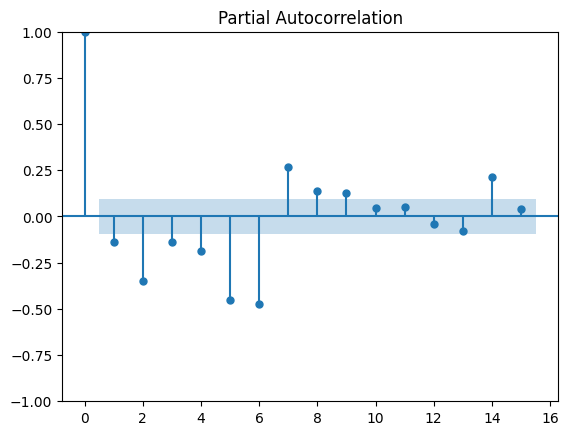

In [18]:
ny_diff_weekly = ny_series.diff(1).dropna()
plot_pacf(ny_diff_weekly, lags = 15);

### Running throwugh SARIMA with AR (1), AR(3), AR(5) and AR(6) and S(7)

In [19]:
ny = ny_series.copy()

ny.index = pd.to_datetime(ny.index)
ny = ny.sort_index().asfreq("D")

SPLIT = 0.8
split_idx = int(len(ny) * SPLIT)
ny_train, ny_test = ny.iloc[:split_idx], ny.iloc[split_idx:]


## Testing for varied parameters
After testing different d, q and D, P, Q with differnt numbers running through to get a good AIC

In [20]:
seasonal_period = 7
d, q = 1, 0
D, P, Q = 1, 0, 0
p_list = [1, 3, 5, 6]

models = {}
results = {}

for p in p_list:
    spec = f"SARIMA({p},{d},{q})x({P},{D},{Q},{seasonal_period})"
    try:
        model = SARIMAX(ny_train, order=(p, d, q),
            seasonal_order=(P, D, Q, seasonal_period),
            enforce_stationarity=False,
            enforce_invertibility=False,
        )
        res = model.fit(disp=False)
        models[p] = model
        results[p] = res
        print(f"{spec}  ->  AIC: {res.aic:.2f}")
    except Exception as e:
        print(f"{spec}  ->  failed to converge: {e}")

if not results:
    raise RuntimeError("All fixed-spec SARIMA fits failed. Check data/frequency.")



SARIMA(1,1,0)x(0,1,0,7)  ->  AIC: 2360.25
SARIMA(3,1,0)x(0,1,0,7)  ->  AIC: 2315.42
SARIMA(5,1,0)x(0,1,0,7)  ->  AIC: 2303.94
SARIMA(6,1,0)x(0,1,0,7)  ->  AIC: 2277.95


## Section of Code Added later after realizing that there is a package that gives you the best SARIMAX model 
Will work with this in next iteration

In [21]:
#pip install pmdarima

In [22]:
from pmdarima import auto_arima

pmmodel = auto_arima(ny_train,
                  seasonal=True, m=7,
                  start_p=0, start_q=0,
                  max_p=6, max_q=6,
                  d=None, D=None,  # Let the model determine differencing
                  test='adf',
                  trace=True,
                  error_action='ignore',
                  suppress_warnings=True,
                  stepwise=True)



Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=2357.037, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=2679.263, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=2387.456, Time=0.09 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=2504.476, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=2677.265, Time=0.01 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=2552.322, Time=0.04 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=2428.999, Time=0.04 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=2354.731, Time=0.23 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=2389.265, Time=0.11 sec
 ARIMA(0,1,0)(2,0,2)[7] intercept   : AIC=2360.333, Time=0.33 sec
 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=2355.721, Time=0.19 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=2318.777, Time=0.25 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=2318.427, Time=0.11 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=2540.575, Time=0.06 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept

In [23]:
print(pmmodel.summary())

                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                  336
Model:             SARIMAX(1, 1, 1)x(2, 0, [1, 2], 7)   Log Likelihood               -1136.729
Date:                                Wed, 20 Aug 2025   AIC                           2289.459
Time:                                        16:05:57   BIC                           2319.972
Sample:                                    01-13-2020   HQIC                          2301.623
                                         - 12-13-2020                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0002      0.003     -0.058      0.954      -0.006       0.005
ar.

## Best Akaike Criterion 
SARIMA(6,1,0) X (0,1,0,7) (We might be overfitting so making sure we remove the 2nd, 4th and 5th differences as they are irrelevant)

### Checking if the Hypothesis that We might be overfitting works or not

In [24]:
ORDER = (6, 1, 0)        # AR(6), d=1, q=0
SORDER = (0, 1, 0, 7)

full_model = SARIMAX( ny_train, order=ORDER, seasonal_order=SORDER, enforce_stationarity=False, enforce_invertibility=False,)
full_res = full_model.fit(disp=False)

In [25]:
hypo_model = SARIMAX( ny_train, order=ORDER, seasonal_order=SORDER, enforce_stationarity=False, enforce_invertibility=False)
# Model 
hypo_res = hypo_model.fit_constrained({"ar.L2": 0.0, "ar.L4": 0.0, "ar.L5": 0.0}, disp=False)

In [26]:
#Corrected AIC (from reference book)
def aicc(aic, k, n):
    return aic + (2*k*(k+1)) / (n - k - 1)

In [27]:
n = int(full_res.nobs)
k_full = len(full_res.params)
k_rest = len(hypo_res.params)

In [28]:
summary = pd.DataFrame({
    "model": ["Full AR", "Restricted AR"],
    "k_params": [k_full, k_rest],
    "loglike": [full_res.llf, hypo_res.llf],
    "AIC": [full_res.aic, hypo_res.aic],
    "BIC": [full_res.bic, hypo_res.bic],
    "AICc": [aicc(full_res.aic, k_full, n), aicc(hypo_res.aic, k_rest, n)],
})
summary

,model,k_params,loglike,AIC,BIC,AICc
0,Full AR,7,-1131.976466,2277.952932,2304.374793,2278.294396
1,Restricted AR,7,-1154.783400,2317.566799,2332.665005,2317.908263


### INSIGHTS
 Full Model with no Restricted lags are giving better information and should be kept we choose full model for now SARIMA(6,1,0)(0,1,0,7)

## Forecast

In [29]:
import warnings
warnings.filterwarnings("ignore")

n_forecast = len(ny_test)
pred = full_res.get_forecast(steps=n_forecast)
fc_mean = pred.predicted_mean
fc_ci = pred.conf_int()

# Align forecast index to test index (if needed)
fc_mean.index = ny_test.index
fc_ci.index = ny_test.index

# show some values
print("Forecast head:\n", fc_mean.head())
print("95% CI head:\n", fc_ci.head())



Forecast head:
 date
2020-12-14     94.601404
2020-12-15     98.932755
2020-12-16    100.974923
2020-12-17    106.675853
2020-12-18    121.808117
Freq: D, Name: predicted_mean, dtype: float64
95% CI head:
             lower New York  upper New York
date                                      
2020-12-14       78.651665      110.551142
2020-12-15       81.424429      116.441082
2020-12-16       82.444993      119.504853
2020-12-17       86.671653      126.680052
2020-12-18       99.827205      143.789029


### Visualization based on SARIMA

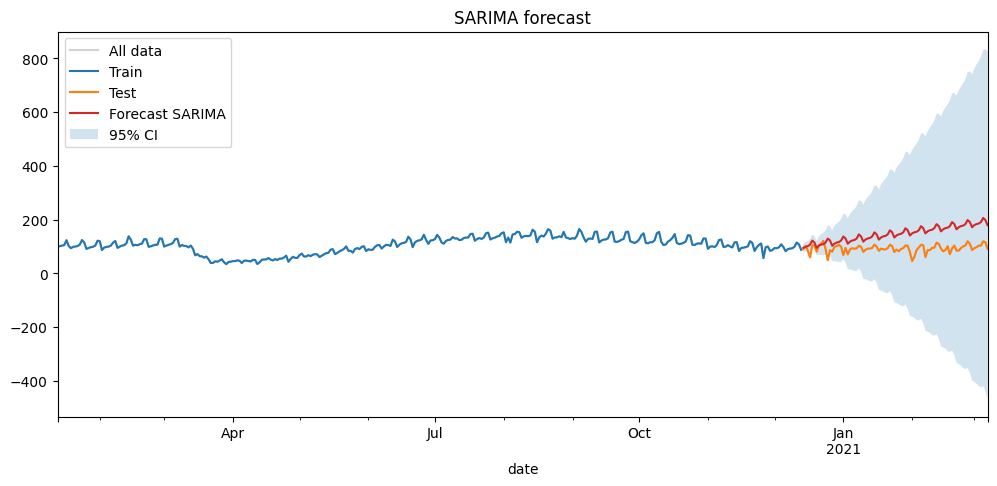

In [30]:
ax = ny.plot(color="lightgray", figsize=(12, 5), label="All data")
ny_train.plot(ax=ax, color="C0", label="Train")
ny_test.plot(ax=ax, color="C1", label="Test")
fc_mean.plot(ax=ax, color="C3", label=f"Forecast SARIMA")
ax.fill_between(ny_test.index, fc_ci.iloc[:, 0], fc_ci.iloc[:, 1], alpha=0.2, label="95% CI")
ax.set_title(f"SARIMA forecast")
ax.legend()
plt.show()

### MAE and RMSE for the Model

In [31]:
aligned = pd.concat([ny_test.rename("y_true"), fc_mean.rename("y_pred")], axis=1).dropna()
err = aligned["y_pred"] - aligned["y_true"]
mae  = np.mean(np.abs(err))
rmse = np.sqrt(np.mean(err**2))
print(f"MAE:  {mae:.6f}")
print(f"RMSE: {rmse:.6f}")

MAE:  54.664152
RMSE: 60.855139


## For FL, LA, PA and CA

Thought of a Sawant's Metric - based on my understanding of all the underlying metrics to judge the best model probably not the best metric just based on intuition

score = ((RMSE + MAE) / 2) * sqrt(AICc)

## PROMPT 1 Used
Create a consolidated function based on the ipynb in a different file SARIMA.py using the testing for a given time series  in a PD.
Series format that does all of testing to fit the best SARIMA model by changing changing p and d as first priority, and later q and P,D,Q and fix S = 7 and fits the best one. 
Make sure all parameters are less than 7 as we clearly see a seasonality of 7. Use AICC to judge the best model  

Few Other Prompts to make sure things work

## PROMPT 2 Used
Create a hybrid metric to judge the resultant model using 
Combines MAE, RMSE , and AICc metrics to something simple like multiplication of (Avg of RMSE and MAE) and root of AICc 

### Steps taken to make sure we get the best Time Series (Code written by AI)
Step 1: Find best non-seasonal differencing (d)  
Tests d values from 0 to 2 (or uses provided d)  
Uses a simple AR(1) model to evaluate each d  
Step 2: Find best AR order (p)  
Tests p values from 0 to max_order (default 7)  
Keeps the best d from previous step  
Step 3: Find best MA order (q)  
Tests q values from 0 to max_order  
Uses best p and d from previous steps  
Step 4: Find best seasonal differencing (D)  
Tests D values 0 and 1 (or uses provided D)  
Uses best (p,d,q) from previous steps  
Step 5: Find best seasonal AR order (P)  
Tests P values from 0 to max_order  
Uses best (p,d,q) and D from previous steps  
Step 6: Find best seasonal MA order (Q)  
Tests Q values from 0 to max_order  
Uses best (p,d,q), D, and P from previous steps  

### Metrics to see if the Model Performing well

The plotted SARIMA only takes under consideration the best AICc to judge the MOdel

In [32]:
import importlib
import SARIMA
importlib.reload(SARIMA)
from SARIMA import find_best_sarima, fit_sarima, forecast_sarima, plot_forecast,find_best_sarima_hybrid

In [33]:
# Find the best SARIMA model for pa_series
# best_model, best_order, best_seasonal_order, results = find_best_sarima_hybrid(pa_series)

best_model, best_order, best_seasonal_order, results = find_best_sarima(pa_series)

Step 1: Finding best non-seasonal differencing (d)
d=0 - AICc: 3572.23
d=1 - AICc: 3558.61
d=2 - AICc: 3826.55
Best d: 1

Step 2: Finding best AR order (p)
p=0 - AICc: 3564.89
p=1 - AICc: 3558.61
p=2 - AICc: 3487.68
p=3 - AICc: 3474.83
p=4 - AICc: 3454.87
p=5 - AICc: 3337.65
p=6 - AICc: 3170.06
Best p: 6

Step 3: Finding best MA order (q)
q=0 - AICc: 3170.06
q=1 - AICc: 3135.84
q=2 - AICc: 3132.77
q=3 - AICc: 3129.59
q=4 - AICc: 3125.75
q=5 - AICc: 3116.88
q=6 - AICc: 3094.86
Best q: 6

Step 4: Finding best seasonal differencing (D)
D=0 - AICc: 3094.86
D=1 - AICc: 3011.45
Best D: 1

Step 5: Finding best seasonal AR order (P)
P=0 - AICc: 3011.45
P=1 - AICc: 2970.35
P=2 - AICc: 2915.21
P=3 - AICc: 2865.82
P=4 - AICc: 2820.57
P=5 - AICc: 2775.93
P=6 - AICc: 2728.34
Best P: 6

Step 6: Finding best seasonal MA order (Q)
Q=0 - AICc: 2728.34
Q=1 - AICc: 2732.52
Q=2 - AICc: 2727.17
Q=3 - AICc: 2730.66
Q=4 - AICc: 2730.35
Q=5 - AICc: 2728.51
Q=6 - AICc: 2723.95
Best Q: 6

Final Model:
SARIMA(6,

In [34]:
# Make forecasts
forecast, conf_int = forecast_sarima(best_model, steps=14)  # 14-day foreca

Fitting the model...


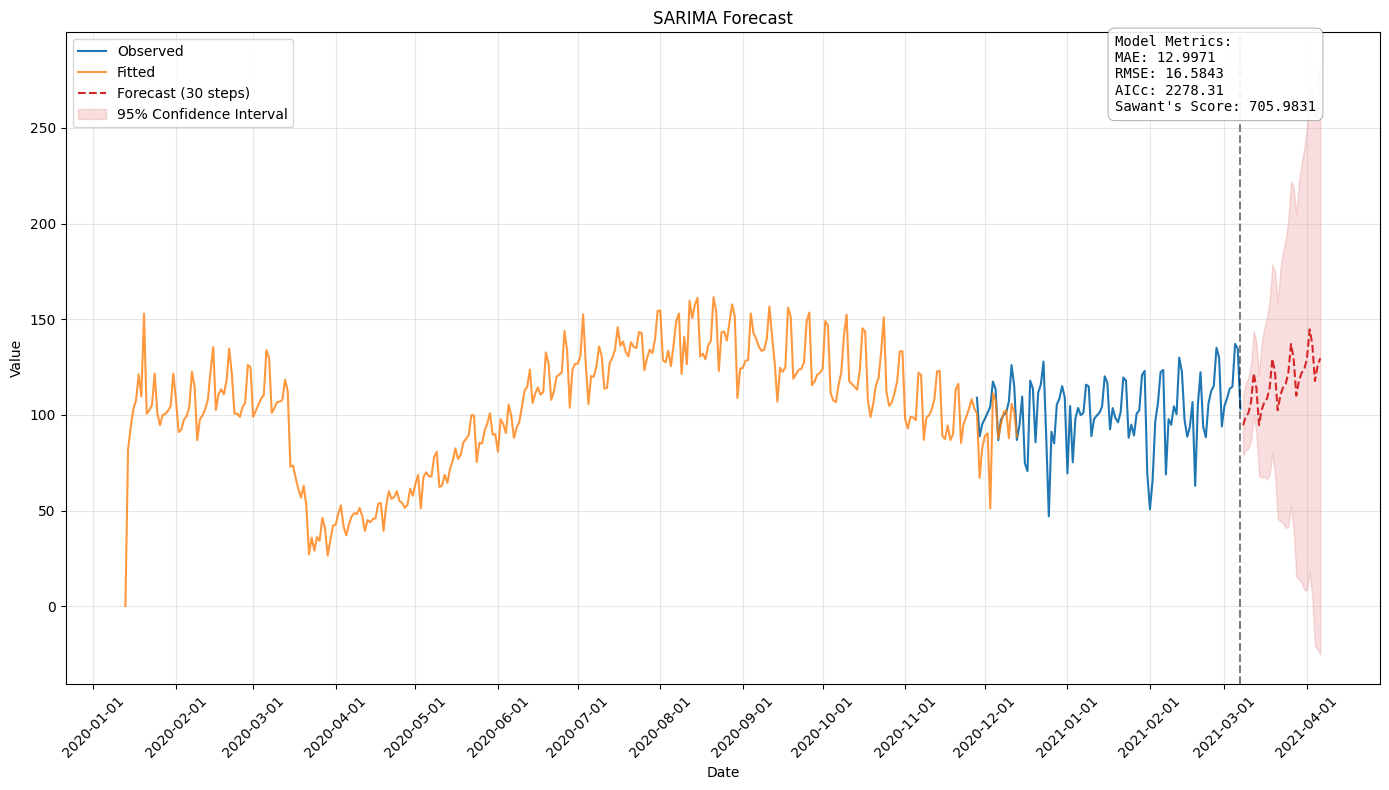

(2020-12-14     94.601404
 2020-12-15     98.932755
 2020-12-16    100.974923
 2020-12-17    106.675853
 2020-12-18    121.808117
 2020-12-19    114.037642
 2020-12-20     94.648869
 2020-12-21    102.704355
 2020-12-22    106.683826
 2020-12-23    108.459667
 2020-12-24    114.139268
 2020-12-25    129.329404
 2020-12-26    121.875466
 2020-12-27    102.395894
 2020-12-28    110.252232
 2020-12-29    114.259773
 2020-12-30    116.122522
 2020-12-31    121.825115
 2021-01-01    137.025773
 2021-01-02    129.497640
 2021-01-03    110.008561
 2021-01-04    117.915020
 2021-01-05    121.934889
 2021-01-06    123.777829
 2021-01-07    129.471972
 2021-01-08    144.665014
 2021-01-09    137.151640
 2021-01-10    117.671882
 2021-01-11    125.569138
 2021-01-12    129.582033
 Freq: D, Name: predicted_mean, dtype: float64,
             lower New York  upper New York
 2020-12-14       78.651665      110.551142
 2020-12-15       81.424429      116.441082
 2020-12-16       82.444993      119.504

In [35]:
# Then plot using the entire tuple
plot_forecast(pa_series, model, steps=30)

In [36]:
# Find the best SARIMA model
best_model, best_order, best_seasonal_order, results = find_best_sarima(tx_series)


Step 1: Finding best non-seasonal differencing (d)
d=0 - AICc: 3559.46
d=1 - AICc: 3550.76
d=2 - AICc: 3810.86
Best d: 1

Step 2: Finding best AR order (p)
p=0 - AICc: 3552.23
p=1 - AICc: 3550.76
p=2 - AICc: 3472.44
p=3 - AICc: 3464.17
p=4 - AICc: 3447.93
p=5 - AICc: 3325.61
p=6 - AICc: 3216.98
Best p: 6

Step 3: Finding best MA order (q)
q=0 - AICc: 3216.98
q=1 - AICc: 3112.78
q=2 - AICc: 3056.00
q=3 - AICc: 3038.73
q=4 - AICc: 3038.77
q=5 - AICc: 3036.55
q=6 - AICc: 2956.21
Best q: 6

Step 4: Finding best seasonal differencing (D)
D=0 - AICc: 2956.21
D=1 - AICc: 2970.77
Best D: 0

Step 5: Finding best seasonal AR order (P)
P=0 - AICc: 2956.21
P=1 - AICc: 2929.29
P=2 - AICc: 2890.14
P=3 - AICc: 2853.98
P=4 - AICc: 2790.12
P=5 - AICc: 2745.49
P=6 - AICc: 2701.24
Best P: 6

Step 6: Finding best seasonal MA order (Q)
Q=0 - AICc: 2701.24
Q=1 - AICc: 2687.28
Q=2 - AICc: 2683.34
Q=3 - AICc: 2681.29
Q=4 - AICc: 2683.08
Q=5 - AICc: 2684.87
Q=6 - AICc: 2680.62
Best Q: 6

Final Model:
SARIMA(6,

Fitting the model...


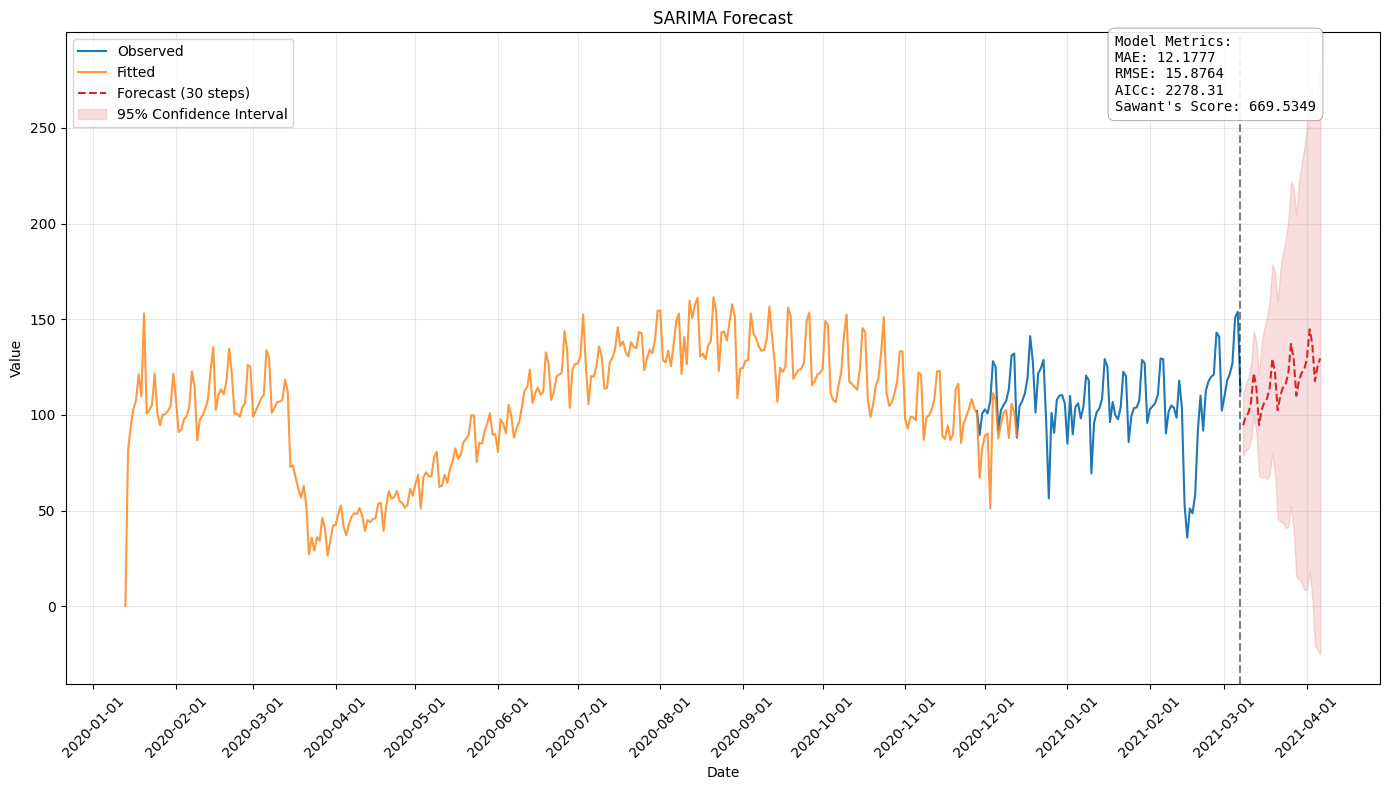

(2020-12-14     94.601404
 2020-12-15     98.932755
 2020-12-16    100.974923
 2020-12-17    106.675853
 2020-12-18    121.808117
 2020-12-19    114.037642
 2020-12-20     94.648869
 2020-12-21    102.704355
 2020-12-22    106.683826
 2020-12-23    108.459667
 2020-12-24    114.139268
 2020-12-25    129.329404
 2020-12-26    121.875466
 2020-12-27    102.395894
 2020-12-28    110.252232
 2020-12-29    114.259773
 2020-12-30    116.122522
 2020-12-31    121.825115
 2021-01-01    137.025773
 2021-01-02    129.497640
 2021-01-03    110.008561
 2021-01-04    117.915020
 2021-01-05    121.934889
 2021-01-06    123.777829
 2021-01-07    129.471972
 2021-01-08    144.665014
 2021-01-09    137.151640
 2021-01-10    117.671882
 2021-01-11    125.569138
 2021-01-12    129.582033
 Freq: D, Name: predicted_mean, dtype: float64,
             lower New York  upper New York
 2020-12-14       78.651665      110.551142
 2020-12-15       81.424429      116.441082
 2020-12-16       82.444993      119.504

In [37]:
# Make forecasts
forecast, conf_int = forecast_sarima(best_model, steps=14)  # 14-day foreca

# Basic usage:
plot_forecast(tx_series, model, steps=30)

In [38]:
# Find the best SARIMA model
best_model, best_order, best_seasonal_order, results = find_best_sarima(ca_series)

Step 1: Finding best non-seasonal differencing (d)
d=0 - AICc: 3274.97
d=1 - AICc: 3266.74
d=2 - AICc: 3527.25
Best d: 1

Step 2: Finding best AR order (p)
p=0 - AICc: 3267.52
p=1 - AICc: 3266.74
p=2 - AICc: 3185.70
p=3 - AICc: 3177.52
p=4 - AICc: 3151.66
p=5 - AICc: 3026.86
p=6 - AICc: 2919.15
Best p: 6

Step 3: Finding best MA order (q)
q=0 - AICc: 2919.15
q=1 - AICc: 2848.74
q=2 - AICc: 2821.59
q=3 - AICc: 2814.46
q=4 - AICc: 2814.46
q=5 - AICc: 2802.87
q=6 - AICc: 2739.60
Best q: 6

Step 4: Finding best seasonal differencing (D)
D=0 - AICc: 2739.60
D=1 - AICc: 2704.69
Best D: 1

Step 5: Finding best seasonal AR order (P)
P=0 - AICc: 2704.69
P=1 - AICc: 2662.95
P=2 - AICc: 2622.07
P=3 - AICc: 2567.37
P=4 - AICc: 2524.34
P=5 - AICc: 2473.82
P=6 - AICc: 2428.65
Best P: 6

Step 6: Finding best seasonal MA order (Q)
Q=0 - AICc: 2428.65
Q=1 - AICc: 2433.36
Q=2 - AICc: 2419.69
Q=3 - AICc: 2427.35
Q=4 - AICc: 2428.75
Q=5 - AICc: 2430.59
Q=6 - AICc: 2426.61
Best Q: 2

Final Model:
SARIMA(6,

Fitting the model...


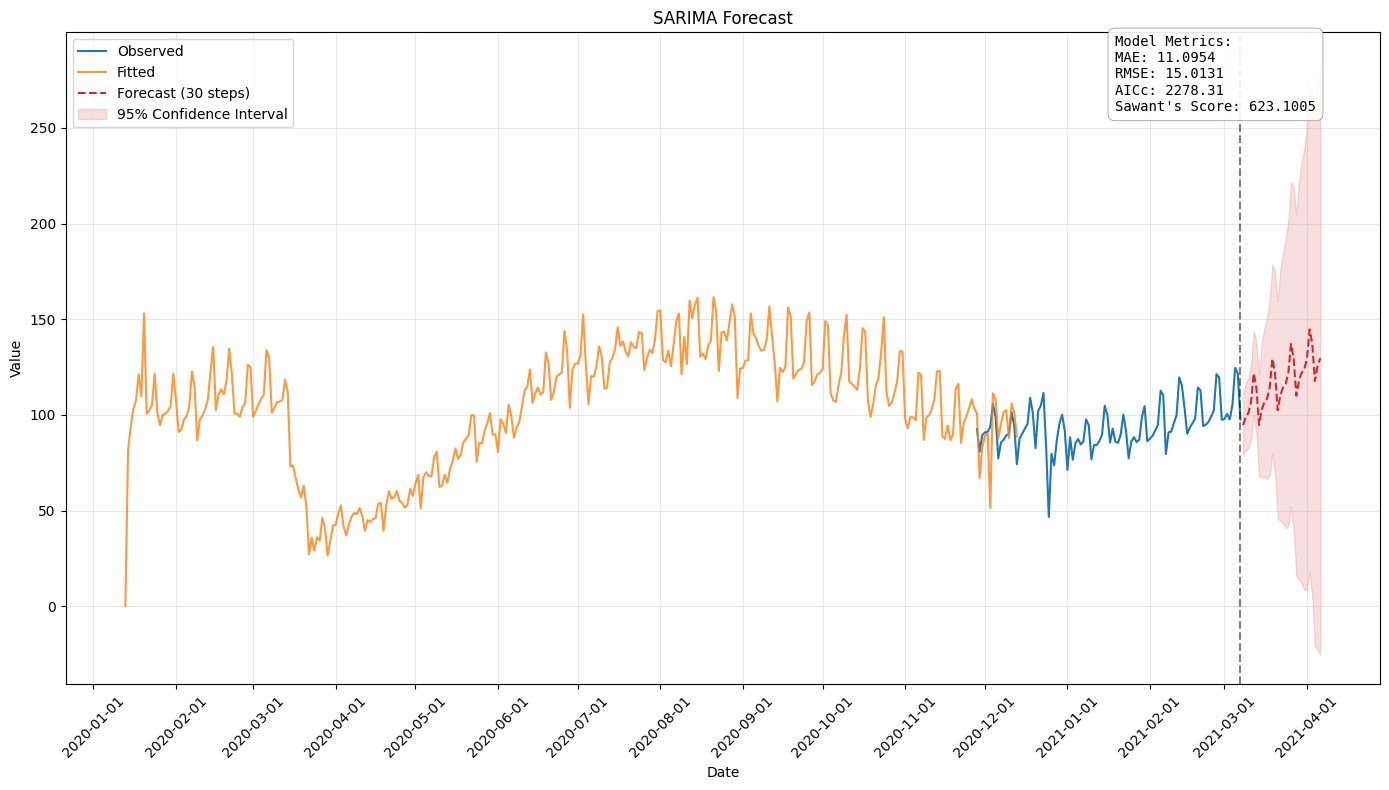

(2020-12-14     94.601404
 2020-12-15     98.932755
 2020-12-16    100.974923
 2020-12-17    106.675853
 2020-12-18    121.808117
 2020-12-19    114.037642
 2020-12-20     94.648869
 2020-12-21    102.704355
 2020-12-22    106.683826
 2020-12-23    108.459667
 2020-12-24    114.139268
 2020-12-25    129.329404
 2020-12-26    121.875466
 2020-12-27    102.395894
 2020-12-28    110.252232
 2020-12-29    114.259773
 2020-12-30    116.122522
 2020-12-31    121.825115
 2021-01-01    137.025773
 2021-01-02    129.497640
 2021-01-03    110.008561
 2021-01-04    117.915020
 2021-01-05    121.934889
 2021-01-06    123.777829
 2021-01-07    129.471972
 2021-01-08    144.665014
 2021-01-09    137.151640
 2021-01-10    117.671882
 2021-01-11    125.569138
 2021-01-12    129.582033
 Freq: D, Name: predicted_mean, dtype: float64,
             lower New York  upper New York
 2020-12-14       78.651665      110.551142
 2020-12-15       81.424429      116.441082
 2020-12-16       82.444993      119.504

In [39]:
# Make forecasts
forecast, conf_int = forecast_sarima(best_model, steps=14)  # 14-day foreca

# Basic usage:
plot_forecast(ca_series, model, steps=30)

In [40]:
# Find the best SARIMA model
best_model, best_order, best_seasonal_order, results = find_best_sarima(fl_series)



Step 1: Finding best non-seasonal differencing (d)
d=0 - AICc: 3393.68
d=1 - AICc: 3378.97
d=2 - AICc: 3655.67
Best d: 1

Step 2: Finding best AR order (p)
p=0 - AICc: 3386.34
p=1 - AICc: 3378.97
p=2 - AICc: 3293.21
p=3 - AICc: 3282.67
p=4 - AICc: 3268.09
p=5 - AICc: 3154.40
p=6 - AICc: 2967.49
Best p: 6

Step 3: Finding best MA order (q)
q=0 - AICc: 2967.49
q=1 - AICc: 2870.18
q=2 - AICc: 2832.92
q=3 - AICc: 2827.02
q=4 - AICc: 2825.35
q=5 - AICc: 2818.62
q=6 - AICc: 2772.72
Best q: 6

Step 4: Finding best seasonal differencing (D)
D=0 - AICc: 2772.72
D=1 - AICc: 2719.38
Best D: 1

Step 5: Finding best seasonal AR order (P)
P=0 - AICc: 2719.38
P=1 - AICc: 2678.29
P=2 - AICc: 2662.21
P=3 - AICc: 2606.22
P=4 - AICc: 2567.04
P=5 - AICc: 2521.66
P=6 - AICc: 2468.90
Best P: 6

Step 6: Finding best seasonal MA order (Q)
Q=0 - AICc: 2468.90
Q=1 - AICc: 2452.55
Q=2 - AICc: 2451.42
Q=3 - AICc: 2450.27
Q=4 - AICc: 2448.51
Q=5 - AICc: 2451.51
Q=6 - AICc: 2447.56
Best Q: 6

Final Model:
SARIMA(6,

Fitting the model...


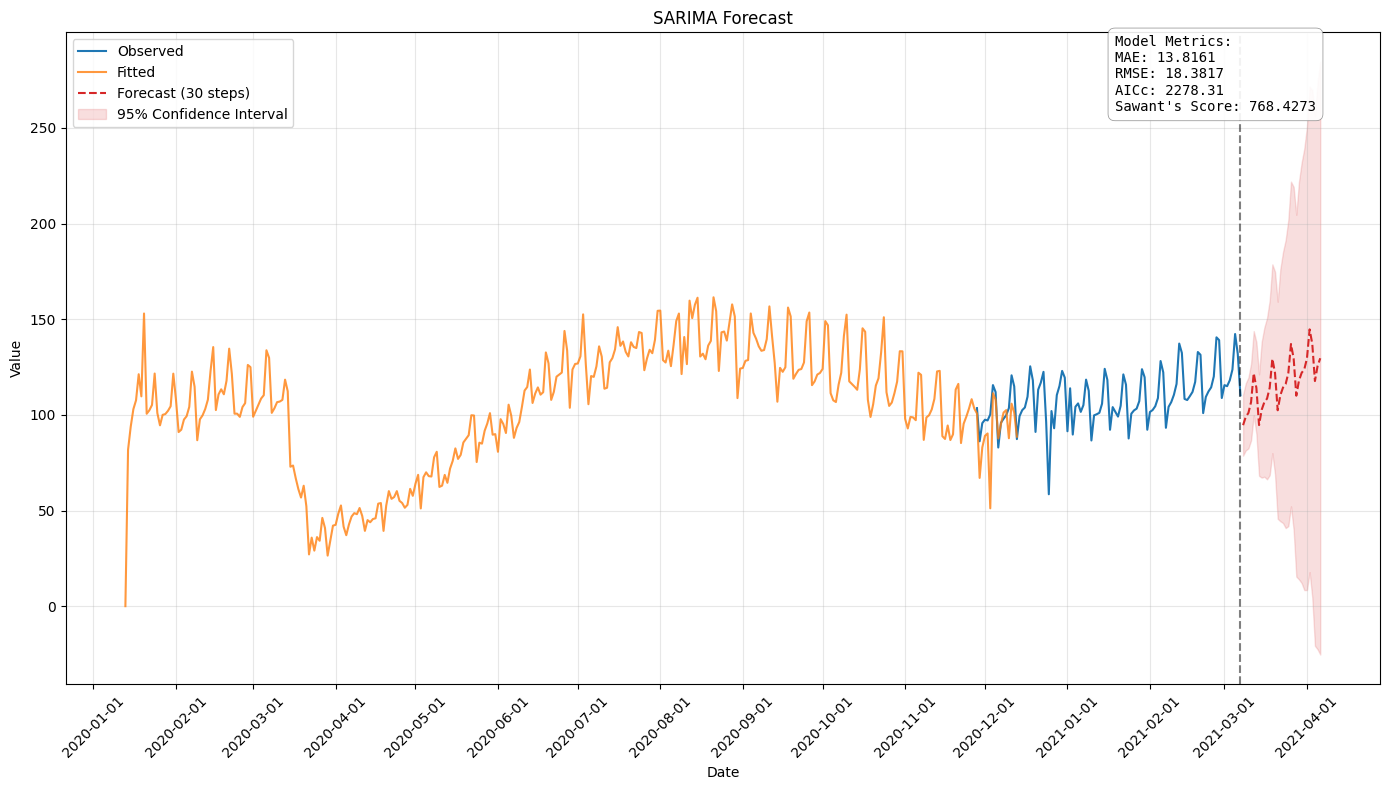

(2020-12-14     94.601404
 2020-12-15     98.932755
 2020-12-16    100.974923
 2020-12-17    106.675853
 2020-12-18    121.808117
 2020-12-19    114.037642
 2020-12-20     94.648869
 2020-12-21    102.704355
 2020-12-22    106.683826
 2020-12-23    108.459667
 2020-12-24    114.139268
 2020-12-25    129.329404
 2020-12-26    121.875466
 2020-12-27    102.395894
 2020-12-28    110.252232
 2020-12-29    114.259773
 2020-12-30    116.122522
 2020-12-31    121.825115
 2021-01-01    137.025773
 2021-01-02    129.497640
 2021-01-03    110.008561
 2021-01-04    117.915020
 2021-01-05    121.934889
 2021-01-06    123.777829
 2021-01-07    129.471972
 2021-01-08    144.665014
 2021-01-09    137.151640
 2021-01-10    117.671882
 2021-01-11    125.569138
 2021-01-12    129.582033
 Freq: D, Name: predicted_mean, dtype: float64,
             lower New York  upper New York
 2020-12-14       78.651665      110.551142
 2020-12-15       81.424429      116.441082
 2020-12-16       82.444993      119.504

In [41]:
# Make forecasts
forecast, conf_int = forecast_sarima(best_model, steps=14)  # 14-day foreca

plot_forecast(fl_series, model, steps=30)